In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
# you should now be able to import src
# go to parent dir
# otherwise try os.path.join(os.path.dirname(os.path.realpath(os.getcwd())), 'src')
sys.path.append(os.path.dirname(os.path.realpath(os.getcwd())))
from src.radar import RadarCollection  # this should not throw error
from src.preprocessed_image import PreprocessedImageCollection
import cv2
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

In [3]:
data_path = os.path.join(os.path.dirname(os.path.realpath(os.getcwd())), 'data')
aemet_folders_path = os.path.join(*[data_path, 'aemet', '10min'])
radar_path = os.path.join(data_path, 'radars.yaml')
aemet_color_scheme_path = os.path.join(data_path, 'aemet_color_scheme.png')

In [4]:
aemet_folders_path

'C:\\Users\\Shaheryar\\Desktop\\Hackathon\\wirelessdna_winter_hackathon_weather_interference_cleaning\\data\\aemet\\10min'

In [5]:
rc = RadarCollection.from_file_path(radar_path)
dataset_loader = PreprocessedImageCollection.from_radar_collection_and_aemet_folders_path(rc, aemet_folders_path)

In [6]:
dataset_loader.size()

46696

In [100]:
# Add the dates you want to process
date_range={
    'before_day':22,
    'after_day':21,
    'before_month':5,
    'after_month':5
}
radar='va'

In [101]:
pic=dataset_loader.filter_based_on_radar_code_and_time(before_dt=datetime(year=2022, month=date_range['before_month'], day=date_range['before_day']),
                                        after_dt=datetime(year=2022, month=date_range['after_month'], day=date_range['after_day']),
                                           radar_code=radar)

In [102]:
pic.size()

145

In [103]:
idx=40

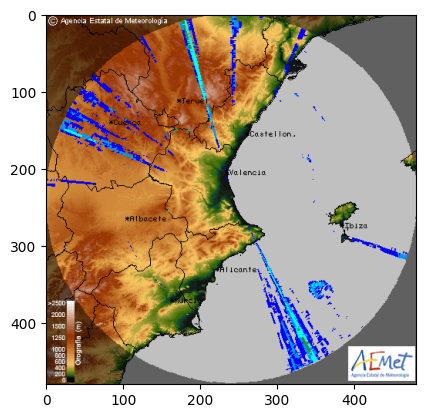

In [104]:
org_path=pic.get_image(idx).file_path
org_img=Image.open(org_path).convert('RGB')
cropped_org_img=np.asarray(org_img)[0:480,:,:]
plt.imshow(cropped_org_img)

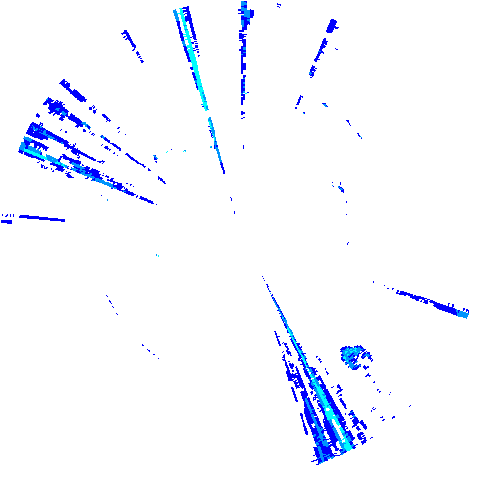

In [105]:
mask_img=(pic.get_image(idx).generate_initial_mask())
mask_img

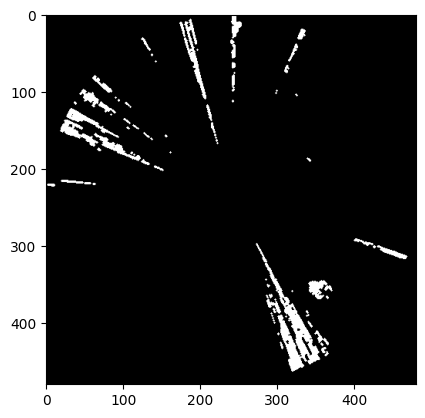

In [106]:
def preprocess_img(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.bitwise_not(gray)
    ret,thresh = cv2.threshold(gray,1,255,cv2.THRESH_BINARY)
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    inp_img=opening
    return inp_img
p_img=preprocess_img(np.array(mask_img))
plt.imshow(p_img,cmap='gray')

In [107]:
base_path=r'C:\Users\Shaheryar\Desktop\Hackathon\wirelessdna_winter_hackathon_weather_interference_cleaning\data\preprocessed_data'
new_dataset_path=os.path.join(base_path,radar+"_20220"+str(date_range['before_month'])+str(date_range['before_day']))
os.mkdir(new_dataset_path)

  0%|                                                                                                                                      | 0/145 [00:01<?, ?it/s]


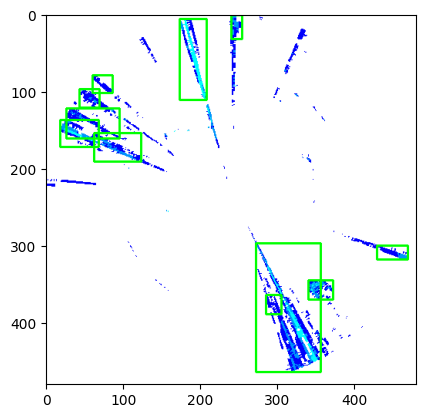

In [108]:
def generate_data(pic,idx):
    count = 0
    mask_img=(pic.get_image(idx).generate_initial_mask())
    img = np.array(mask_img)
    inp_img=preprocess_img(img)
    draw_img=img.copy()
    contours, hierarchy = cv2.findContours(inp_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    filtered_cts=[]
    for c in contours:
        (x, y, w, h) = cv2.boundingRect(c)
        area = cv2.contourArea(c)
        if area>120:
            feature_img = np.zeros(img.shape)
            (x, y, w, h) = cv2.boundingRect(c)
            cv2.drawContours(feature_img, [c], 0, (255,255,255), -1)
            draw_img = cv2.rectangle(draw_img, (x,y), (x+w,y+h), (0,255,0), 2)
        
            pad=15
            roi=feature_img[y:y + h, x:x + w].copy()
            roi=np.pad(roi, pad_width=[(pad, pad),(pad, pad),(0, 0)], mode='constant')
            count=count+1
            filtered_cts.append(c)
            cv2.imwrite(os.path.join(new_dataset_path,str(idx)+'_'+str(count)+'.jpg'),roi)
    plt.imshow(draw_img)
    return filtered_cts
for i in tqdm(range(pic.size())):
    filtered_cts=generate_data(pic,idx)
    break

In [109]:
def detect_interferences(img, margin, radius=200):
    gray = img.convert('L')

    edges = cv2.Canny(np.asarray(gray), 50, 120)
    edges_new = edges

    lines = cv2.HoughLinesP(edges,rho = 1,theta = 1*np.pi/180,threshold = 50,minLineLength = 50,maxLineGap = 50)

    back = cv2.cvtColor(edges,cv2.COLOR_GRAY2RGB)

    if lines is None:
        return [], np.hstack((img, back, back))

    else:
        for i in range(len(lines)):
            for x1,y1,x2,y2 in lines[i]:
                edges_new = cv2.line(np.asarray(edges_new), (x1,y1), (x2,y2), (255,0,0), 2)

        backtorgb1 = cv2.cvtColor(edges_new,cv2.COLOR_GRAY2RGB)

        lines_list = []
        for i in range(len(lines)):
            lines_list.append(list(lines[i][0]))

        remove_indexes = []
        # plt.imshow(edges_new, cmap='gray')
        for index, line in enumerate(lines_list):
            x1,y1,x2,y2 = line[0], line[1], line[2], line[3]
            m = (y2 - y1) / (x2 - x1)
            c = y2 - (m * x2)

            remove = True
            for cx in range(240 - margin, 240 + margin):
                for cy in range(240 - margin, 240 + margin):
                    if cy == (m * cx) + c:
                        remove = False

            if remove:
                remove_indexes.append(index)
        # print('Remove:', remove_indexes)
        for ind in remove_indexes:
            lines_list[ind] = []

        lines_list = [line for line in lines_list if line != []]

        edges = cv2.Canny(np.asarray(gray), 50, 120)
        edges_new = edges


        if lines is None:
            print('No Lines')

        for i, line in enumerate(lines_list):
            x1,y1,x2,y2 = line[0], line[1], line[2], line[3]
            edges_new = cv2.line(np.asarray(edges_new), (x1,y1), (x2,y2), (255,0,0), 2)

        backtorgb2 = cv2.cvtColor(edges_new,cv2.COLOR_GRAY2RGB)

        from scipy.spatial import distance

        remove_indexes = []

#         center = (240, 240)

#         for index, line in enumerate(lines_list):
#             p1, p2 =  (line[0], line[1]), (line[2], line[3])

#             dst1 = distance.euclidean(p1, center)
#             dst2 = distance.euclidean(p2, center)

#             if dst1 < radius or dst2 < radius:
#                 remove_indexes.append(index)

#         for ind in remove_indexes:
#             lines_list[ind] = []

#         lines_list = [line for line in lines_list if line != []]

#         edges = cv2.Canny(np.asarray(gray), 50, 120)
#         edges_new = edges

#         if lines is None:
#             print('No Lines')

#         for i, line in enumerate(lines_list):
#             x1,y1,x2,y2 = line[0], line[1], line[2], line[3]
#             edges_new = cv2.line(np.asarray(edges_new), (x1,y1), (x2,y2), (255,0,0), 2)

        backtorgb3 = cv2.cvtColor(edges_new,cv2.COLOR_GRAY2RGB)


        final = np.hstack((img, backtorgb1, backtorgb3))
        return lines_list, final
def draw_white_lines(img, lines, width=2):
    for i, line in enumerate(lines):
        x1,y1,x2,y2 = line[0], line[1], line[2], line[3]
        img = cv2.line(np.asarray(img), (x1,y1), (x2,y2), (255,255,255), width)
    return img

In [110]:
def process_collection(pic):
    results_arr=[]
    for idx in tqdm(range(pic.size()-1)):
        org_path = pic.get_image(idx).file_path
        img = pic.get_image(idx).generate_initial_mask()
        lines, results_stack = detect_interferences(img, 50)
        removed_lines=draw_white_lines(img,lines,15)
        # Get original image also
        org_path=pic.get_image(idx).file_path
        org_img=Image.open(org_path).convert('RGB')
        cropped_org_img=np.asarray(org_img)[0:480,:,:]
        
        results_stack=np.hstack((cropped_org_img,results_stack,removed_lines))
        results_arr.append(results_stack)
    return results_arr

In [111]:
def generate_video(img_list,output_name='temp_result.gif',is_PIL=True):
    gif=[]
    for image in img_list:
        if is_PIL==False:
              image = Image.fromarray(image.astype('uint8'), 'RGB')
        gif.append(image)
    gif[0].save(output_name, save_all=True,optimize=False, append_images=gif[1:], loop=0)

def save_collection(img_list,output_path):
    i=0 
    for image in img_list:
        i=i+1
        save_path = os.path.join(output_path,str(i)+'.jpg')
        cv2.imwrite(save_path,cv2.cvtColor(image,cv2.COLOR_BGR2RGB))

In [112]:
results_base_path = r'C:\Users\Shaheryar\Desktop\Hackathon\wirelessdna_winter_hackathon_weather_interference_cleaning\results'
results_path= os.path.join(results_base_path,radar+"_20220"+str(date_range['after_month'])+str(date_range['after_day']))
try:
    os.mkdir(results_path)
except:
    pass

In [113]:
results_arr=process_collection(pic)

  6%|███████▉                                                                                                                      | 9/144 [00:16<04:11,  1.86s/it]C:\Users\Shaheryar\AppData\Local\Temp\ipykernel_18332\1229490618.py:29: RuntimeWarning: divide by zero encountered in scalar divide
  m = (y2 - y1) / (x2 - x1)
C:\Users\Shaheryar\AppData\Local\Temp\ipykernel_18332\1229490618.py:35: RuntimeWarning: invalid value encountered in scalar add
  if cy == (m * cx) + c:
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [04:42<00:00,  1.96s/it]


In [114]:
generate_video(results_arr,output_name=os.path.join(results_path,'live.gif'),is_PIL=False)

In [115]:
save_collection(results_arr,results_path)